In [ ]:
import pandas as pd
import numpy as np
import random

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
path1 = "/content/drive/Shareddrives/DatosSIMA/meteo_flags.xlsx"
path2 = "/content/drive/Shareddrives/DatosSIMA/pollu_flags.xlsx"


In [ ]:
from pandas.core import apply
def clean_data(path1, path2):

  ## leer datos
  meteo_dict = read_all_sheets(path1)
  pollu_dict = read_all_sheets(path2)

  # juntar datos de diccionario en un dataframe
  meteo_data_raw = merge_data_with_flags(meteo_dict, 'Fecha')
  pollu_data_raw = merge_data_with_flags(pollu_dict, 'Fecha')

  # filtrar por banderas
  meteo_data = apply_flags(meteo_data_raw, 'meteo')
  pollu_data = apply_flags(pollu_data_raw, 'pollu')

  # fusionar dataframes
  all_data = merge_dataframes(meteo_data, pollu_data, 'date')




  return meteo_data, pollu_data, all_data




In [ ]:
import xlrd

from pandas.core import apply

# A esta función le das la ruta del archivo xlsx de varias hojas y te regresa un 
# diccionario con el nombre de cada hoja como llave la cual contiene el dataframe 
# de dicha hoja.

def read_all_sheets(path):  
  df_dict = {}
  for i in xlrd.open_workbook(path, on_demand=True).sheet_names(): 
    globals()[f'{i}'] = pd.read_excel(path, sheet_name=i)
    df_dict[i] = globals()[f'{i}']
  return df_dict

# A esta función le das un diccionario que guarde dataframes en cada uno de sus elementos, en este caso 
# para las banderas te lee cada una de las banderas existentes de todas las hojas y te regresa una lista 
# con todas las banderas existentes

def flags(df_dict):
  flags = set()
  for key in df_dict.keys():
    df = df_dict[key][key+'f'].value_counts().rename_axis('unique_values').reset_index(name='counts')
    flags = flags | set(df['unique_values'])
    flags_list = list(flags)
  return flags_list 

# A esta función le das un diccionario que guarde dataframes y la lista de banderas existentes
# Para que así te junte en un dataframe todas las banderas y te diga cuantas tiene cada variable

def merge_flags(df_dict, flags_list):
  df = pd.DataFrame({'Flags':flags_list})
  for key in df_dict.keys():  
    aux_df = df_dict[key][key+'f'].value_counts().rename_axis('Flags').reset_index(name=key)
    df = df.merge(aux_df,how='left', left_on='Flags', right_on='Flags').fillna(0)
  df[list(df_dict.keys())] = df[list(df_dict.keys())].astype(int)
  return df

#A esta función le das el diccionario que guarde dataframes y te regresa todos los dataframes existentes
# en un sólo dataframe tomando siempre el de mayor longitud al que se le va a agregar el otro para que 
# no se eliminen fechas y los que no tienen registros en dichas fechas se rellenen con NaN 

def merge_data_no_flags(df_dict, datetime_column ):
  df = pd.DataFrame({datetime_column: []})
  for key in df_dict.keys():
    min = df.shape[0]
    if df_dict[key].shape[0] > min:
      df = df_dict[key].drop(key+'f', axis=1).merge(df,how='left', left_on=datetime_column, right_on=datetime_column)
    else: 
      df = df.merge(df_dict[key].drop(key+'f', axis=1),how='left', left_on=datetime_column, right_on=datetime_column)
  return df

def merge_data_with_flags(df_dict, datetime_column):
  df = pd.DataFrame({datetime_column: []})
  for key in df_dict.keys():
    min = df.shape[0]
    if df_dict[key].shape[0] > min:
      df = df_dict[key].merge(df,how='left', left_on=datetime_column, right_on=datetime_column)
    else: 
      df = df.merge(df_dict[key],how='left', left_on=datetime_column, right_on=datetime_column)
  df = df.rename(columns={datetime_column:"date"})
  return df

# Esta función te mezcla dos diccionarios.

def merge_two_dicts(x, y):
    z = x.copy() 
    z.update(y)  
    return z

# A esta función le das un Dataframe y te regresa los estadísticos principales

def df_stats(data_stats): 
  data_stats = data_stats.select_dtypes(include=np.number)
 
  stats = pd.concat([
            data_stats.describe().T,
            data_stats.mode(numeric_only=True).iloc[0].rename("Mode"),
            data_stats.var( numeric_only=True).rename("Var"),
            data_stats.sem(numeric_only=True).rename('SE Mean'),
            data_stats.isnull().sum().rename('N*')
            ],
            axis = 1)
  stats = stats.rename(columns={"count": "N",
                            "std": "StdDev",
                            "25%":"Q1",
                            "75%":"Q3",
                            "50%":"Median",
                            "min":"Minimum",
                            "max":"Maximum",
                            "mean":"Mean"
                            })
  column_names = ["N",
                  "N*",
                  "Mean", 
                  "SE Mean", 
                  "StdDev", 
                  "Var", 
                  "Minimum", 
                  "Maximum", 
                  "Q1", 
                  "Median", 
                  "Q3", 
                  "Mode"]
  return stats.reindex(columns=column_names)


#A esta función le das un dataframe y te regresa un diccionario con varios dataframes divididos 
# entre los años que existen en las fechas
def data_by_years(df, datetime_column, data_type):
  df[datetime_column] = pd.to_datetime(df[datetime_column], format='%Y-%m-%d %H:%M:%s')
  min_year = min(df[datetime_column]).year
  max_year = max(df[datetime_column]).year
  years_dict = {}
  for i in range(min_year, max_year+1):
      
    x = df.loc[(df[datetime_column] >= str(i)+'-01-01')
                  & (df[datetime_column] < str(i+1)+'-01-01')]
    years_dict[data_type+'_'+str(i)] = x

  return years_dict

#A esta función le das un dataframe de solamente 1 año y te regresa un diccionario con varios dataframes divididos 
# entre los meses que existen en las fechas

def data_by_months(df, datetime_column): 
  df[datetime_column] = pd.to_datetime(df[datetime_column], format='%Y-%m-%d %H:%M:%s') 
  months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
  year = min(df[datetime_column]).year
  months_dict = {}
  for i in months:
    if i != '12':
      month = df.loc[(df[datetime_column] >= str(year)+'-'+i+'-01')
                    & (df[datetime_column] < str(year)+'-'+i+'-01')]
    else:
      month = df.loc[(df[datetime_column] >= str(year)+'-'+i+'-01')
                    & (df[datetime_column] < str(year+1)+'-01-01')]
    months_dict['data_'+str(year)+'_'+i] = month
  return months_dict 

def apply_flags(df, data_type):
  if data_type == 'meteo':
    for i in df.loc[df['SRf'] =='l'].index:
      df.SR[i] = np.nan
      df.SRf[i] = 0
    for i in df.loc[df['WDf'] =='D'].index:
      df.WDf[i] = df.WDf[i]   
    for key in list(df.select_dtypes(include='number').columns):
      df[key+'f'] = df[key+'f'].fillna(0)
      for i in df.loc[df[key+'f'] != 0].index:
        df[key][i] = np.nan 
      df = df.drop(key+'f', axis=1)
  if data_type == 'pollu':
    for key in list(df.select_dtypes(include='number').columns):
      df[key+'f'] = df[key+'f'].fillna(0)
      for i in df.loc[df[key+'f'] != 0].index:
        df[key][i] = np.nan
      df = df.drop(key+'f', axis=1)
  return df




def merge_dataframes(df1, df2, column_to_merge):
  if df2.shape[0] > df1.shape[0]:
    df = df2.merge(df1,how='left', left_on=column_to_merge, right_on=column_to_merge)
  else: 
    df = df1.merge(df2,how='left', left_on=column_to_merge, right_on=column_to_merge)
  return df


 # A esta función le das una ruta en la quieras guardar un dataframe, el dataframe que quieras guardar y el nombre
 # con el que lo quieras guardar y te lo guarda en DRIVE 
  
def save_to_Drive(path,df,name): 
  route = path+name+'.csv'
  with open(route, 'w', encoding = 'utf-8-sig') as f:
    df.to_csv(f, index=False)

def data_description(df): 
  description = pd.concat(
    [df.count().rename('N'),
     df.isnull().sum().rename('N*'),
    df.dtypes.rename("Data Type"),
    df.apply(pd.Series.nunique).rename("# uniq"),
    df.apply(pd.Series.unique).rename("Valores")
    ],
    axis = 1
  )

  description = description.reset_index()
  description = description.rename(columns={"index":"Abreviatura"})

  path = "/content/drive/Shareddrives/DatosSIMA/variables_meanings.xlsx"

  meaning = pd.read_excel(path)

  description = merge_dataframes(meaning,description, 'Abreviatura' )
  return description

In [ ]:
meteo_data, pollu_data, all_data = clean_data(path1, path2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying 

In [ ]:
pollu_data['O3'] = pollu_data['O3']/1000
all_data['O3'] = all_data['O3']/1000

pollu_data['SO2'] = pollu_data['SO2']/1000
all_data['SO2'] = all_data['SO2']/1000

pollu_data['NO'] = pollu_data['NO']/1000
all_data['NO'] = all_data['NO']/1000

pollu_data['NOx'] = pollu_data['NOx']/1000
all_data['NOx'] = all_data['NOx']/1000

pollu_data['NO2'] = pollu_data['NO2']/1000
all_data['NO2'] = all_data['NO2']/1000

meteo_data['RAINF'] = (meteo_data['RAINF']*0.25)*100
all_data['RAINF'] = (all_data['RAINF']*0.25)*100
  

In [ ]:
data_description(all_data)

,Abreviatura,N,N*,Data Type,# uniq,Valores,Contaminante,Unidad
0,date,39394,0,datetime64[ns],39394,"[2017-01-01T00:00:00.000000000, 2017-01-01T01:...",NaN,NaN
1,PM2_5,28882,10512,float64,5611,"[nan, 14.0, 16.0, 52.0, 26.0, 13.0, 57.0, 18.0...",Material Particulado menor a 2.5 micrómetros,µg/m3
2,PM10,37712,1682,float64,3439,"[143.0, 183.0, 142.0, 101.0, 85.0, 52.0, 55.0,...",Material Particulado menor a 10 micrométros,µg/m3
3,SO2,20485,18909,float64,212,"[nan, 0.0039, 0.0038, 0.004, 0.0036, 0.0034, 0...",Dióxido de Azufre,ppb
4,O3,31956,7438,float64,137,"[0.006, 0.005, 0.007, 0.008, 0.017, 0.026, 0.0...",Ozono,ppb
5,CO,28308,11086,float64,633,"[2.47, 2.18, 1.77, 1.93, 1.7, 1.99, 1.61, 1.67...",Monóxido de Carbono,ppm
6,NO,29080,10314,float64,1141,"[0.016, 0.0089, 0.002, 0.0072, 0.0021000000000...",Monóxido de Nitrógeno,ppb
7,NO2,30320,9074,float64,447,"[0.015099999999999999, 0.011699999999999999, 0...",Dióxido de Nitrógeno,ppb
8,NOx,30846,8548,float64,1308,"[0.031100000000000003, 0.0206, 0.0105, 0.0172,...",Óxidos de Nitrógeno,ppb
9,RAINF,36487,2907,float64,14,"[0.0, nan, 0.25, 1.7500000000000002, 1.0, 0.75...",Precipitación,mm/Hr


In [ ]:
TOUTC = [(-20, -9, 'A_Frígido'),
         (-9, 0, 'B_Helada'),
         (0, 7, 'C_MuyFrío'),
         (7, 13, 'D_Frío'),
         (13, 18, 'E_Fresco'),
         (18, 24, 'F_Cómodo'),
         (24, 29, 'G_Caliente'),
         (29, 35, 'H_MuyCaliente'),
         (35, 50, 'I_Tórrido')]

for i, j, k in TOUTC:
  rowIndex = all_data.loc[(all_data['TOUT'] >= i) & (all_data['TOUT'] < j)].index
  all_data.loc[rowIndex, 'tout_c'] = k
  rowIndex = meteo_data.loc[(all_data['TOUT'] >= i) & (meteo_data['TOUT'] < j)].index
  meteo_data.loc[rowIndex, 'tout_c'] = k

In [ ]:
SRC = []

In [ ]:
RHC = [(0, 20, 'A_MuySeco'),
       (20, 40, 'B_Seco'),
       (40, 60, 'C_Confort'),
       (60, 80, 'D_Húmedo'),
       (70, 100, 'C_MuyHúmedo')]

for i, j, k in TOUTC:
  rowIndex = all_data.loc[(all_data['RH'] >= i) & (all_data['RH'] < j)].index
  all_data.loc[rowIndex, 'rh_c'] = k
  rowIndex = meteo_data.loc[(all_data['RH'] >= i) & (meteo_data['RH'] < j)].index
  meteo_data.loc[rowIndex, 'rh_c'] = k

In [ ]:
WDC = [(0, 22.5, 'N'), 
       (22.5, 67.5, 'NE'), 
       (67.5, 112.5, 'E'), 
       (112.5, 157.5, 'SE'), 
       (157.5, 202.5, 'S'), 
       (202.5, 247.5, 'SW'), 
       (247.5, 292.5, 'W'),
       (292.5, 337.5, 'NW'),
       (337.5, 361, 'N')]

for i, j, k in WDC:
  rowIndex = all_data.loc[(all_data['WD'] >= i) & (all_data['WD'] < j)].index
  all_data.loc[rowIndex, 'wd_c'] = k
  rowIndex = meteo_data.loc[(all_data['WD'] >= i) & (meteo_data['WD'] < j)].index
  meteo_data.loc[rowIndex, 'wd_c'] = k

In [ ]:
WSC = [(0, 1, 'A_Calma'), 
       (1, 5, 'B_Ventolina'), 
       (5, 11, 'C_Brisa Muy Débil'), 
       (11, 19, 'D_Brisa Débil'), 
       (19, 29, 'E_Brisa Moderada'), 
       (29, 39, 'F_Brisa Fuerte'), 
       (39, 49, 'G_Brisa Muy Fuerte'),
       (49, 61, 'H_Vendaval Débil'),
       (61, 74, 'Vendaval'),
       (74, 88, 'J_Vendaval FUerte'), 
       (88, 102, 'K_Tormenta'), 
       (102, 117, 'L_Tormenta Violenta'), 
       (117, 134, 'M_Huracán')]

for i, j, k in WSC:
  rowIndex = all_data.loc[(all_data['WS'] >= i) & (all_data['WS'] < j)].index
  all_data.loc[rowIndex, 'ws_c'] = k
  rowIndex = meteo_data.loc[(all_data['WS'] >= i) & (meteo_data['WS'] < j)].index
  meteo_data.loc[rowIndex, 'ws_c'] = k

In [ ]:
meteo_by_years = data_by_years(meteo_data, 'date', 'meteo')
meteo_by_years.keys()

dict_keys(['meteo_2017', 'meteo_2018', 'meteo_2019', 'meteo_2020', 'meteo_2021'])

In [ ]:
pollu_by_years = data_by_years(pollu_data, 'date', 'pollu')
pollu_by_years.keys()

dict_keys(['pollu_2017', 'pollu_2018', 'pollu_2019', 'pollu_2020', 'pollu_2021'])

In [ ]:
all_by_years = data_by_years(all_data, 'date', 'all')
all_by_years.keys()

dict_keys(['all_2017', 'all_2018', 'all_2019', 'all_2020', 'all_2021'])

In [ ]:
all_data

,date,PM2_5,PM10,SO2,O3,CO,NO,NO2,NOx,RAINF,SR,RH,TOUT,PRS,WS,WD,tout_c,rh_c,wd_c,ws_c
0,2017-01-01 00:00:00,NaN,143.0,NaN,0.006,2.47,0.0160,0.0151,0.0311,0.0,0.004,64.0,19.46,709.2,3.0,300.0,F_Cómodo,NaN,NW,B_Ligth Air
1,2017-01-01 01:00:00,NaN,183.0,NaN,0.005,2.18,0.0089,0.0117,0.0206,0.0,0.004,66.0,18.92,708.9,2.0,226.0,F_Cómodo,NaN,SW,B_Ligth Air
2,2017-01-01 02:00:00,NaN,142.0,NaN,0.006,1.77,0.0020,0.0086,0.0105,0.0,0.004,56.0,20.42,708.5,2.6,246.0,F_Cómodo,NaN,SW,B_Ligth Air
3,2017-01-01 03:00:00,NaN,101.0,NaN,0.007,1.93,0.0072,0.0100,0.0172,0.0,0.004,52.0,21.21,708.2,5.4,152.0,F_Cómodo,NaN,SE,C_Light Breeze
4,2017-01-01 04:00:00,NaN,85.0,NaN,0.007,1.70,0.0021,0.0086,0.0107,0.0,0.004,54.0,20.47,707.9,3.6,232.0,F_Cómodo,NaN,SW,B_Ligth Air
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39389,2021-06-30 19:00:00,4.33,24.0,0.0019,0.019,1.89,0.0018,0.0043,0.0063,0.0,0.040,79.0,23.31,711.6,9.4,99.0,F_Cómodo,NaN,E,C_Light Breeze
39390,2021-06-30 20:00:00,3.75,25.0,0.0019,0.017,1.90,0.0019,0.0055,0.0077,0.0,0.010,77.0,23.51,711.8,8.8,74.0,F_Cómodo,NaN,E,C_Light Breeze
39391,2021-06-30 21:00:00,5.51,21.0,0.0018,0.016,1.90,0.0016,0.0055,0.0072,0.0,0.000,82.0,22.62,712.0,5.8,73.0,F_Cómodo,NaN,E,C_Light Breeze
39392,2021-06-30 22:00:00,4.14,24.0,0.0018,0.018,1.86,0.0015,0.0042,0.0058,0.0,0.000,82.0,22.58,712.2,5.2,61.0,F_Cómodo,NaN,NE,C_Light Breeze


In [ ]:
path = "/content/drive/Shareddrives/DatosSIMA/"
for key in pollu_by_years.keys():
  save_to_Drive(path, pollu_by_years[key],key)
  print(key)

for key in meteo_by_years.keys():
  save_to_Drive(path, meteo_by_years[key],key)
  print(key)

for key in all_by_years.keys():
  save_to_Drive(path, all_by_years[key],key)
  print(key)

save_to_Drive(path, all_data,'all_data')
save_to_Drive(path, pollu_data,'pollu_data')
save_to_Drive(path, meteo_data,'meteo_data')

pollu_2017
pollu_2018
pollu_2019
pollu_2020
pollu_2021
meteo_2017
meteo_2018
meteo_2019
meteo_2020
meteo_2021
all_2017
all_2018
all_2019
all_2020
all_2021


In [ ]:
all_data.RAINF.value_counts()

0.00     36454
0.25        10
1.00         6
0.75         5
1.75         2
0.50         2
3.75         1
10.75        1
2.00         1
2.50         1
1.50         1
3.25         1
2.25         1
17.50        1
Name: RAINF, dtype: int64

In [ ]:
all_data.WSC.value_counts().sum(), all_data.WSC.isnull().sum()


(38190, 1204)

In [ ]:
all_data.WDC.value_counts().sum(), all_data.WDC.isnull().sum()


(38270, 1124)

In [ ]:
all_data.PM10.value_counts().rename_axis('unique_values').reset_index(name='counts')

,unique_values,counts
0,29.00,669
1,32.00,654
2,25.00,652
3,36.00,644
4,40.00,580
...,...,...
3434,77.52,1
3435,91.34,1
3436,78.25,1
3437,71.48,1


In [ ]:
df_stats(all_data.drop(['date'], axis=1))

,N,N*,Mean,SE Mean,StdDev,Var,Minimum,Maximum,Q1,Median,Q3,Mode
PM2_5,28882.0,10512,23.941130,0.092254,15.678303,245.809180,2.1700,225.3700,12.6100,20.0000,31.2400,9.0000
PM10,37712.0,1682,52.204350,0.177788,34.525628,1192.019012,2.0000,735.0000,29.0000,45.0000,67.0000,29.0000
SO2,20485.0,18909,0.004295,0.000018,0.002594,0.000007,0.0005,0.0619,0.0027,0.0035,0.0052,0.0034
O3,31956.0,7438,0.028361,0.000112,0.020079,0.000403,0.0010,0.1480,0.0120,0.0250,0.0400,0.0060
CO,28308.0,11086,2.067369,0.006596,1.109695,1.231424,0.0800,14.6000,1.2400,2.0200,2.6500,2.1600
NO,29080.0,10314,0.011454,0.000133,0.022717,0.000516,0.0005,0.5000,0.0027,0.0054,0.0119,0.0015
NO2,30320.0,9074,0.009013,0.000040,0.006949,0.000048,0.0005,0.0781,0.0039,0.0072,0.0125,0.0047
NOx,30846.0,8548,0.019408,0.000142,0.024857,0.000618,0.0010,0.5000,0.0069,0.0128,0.0232,0.0153
RAINF,36487.0,2907,0.001651,0.000600,0.114694,0.013155,0.0000,17.5000,0.0000,0.0000,0.0000,0.0000
SR,38347.0,1047,0.187004,0.001186,0.232344,0.053984,0.0000,1.0960,0.0060,0.1660,0.1840,0.0060


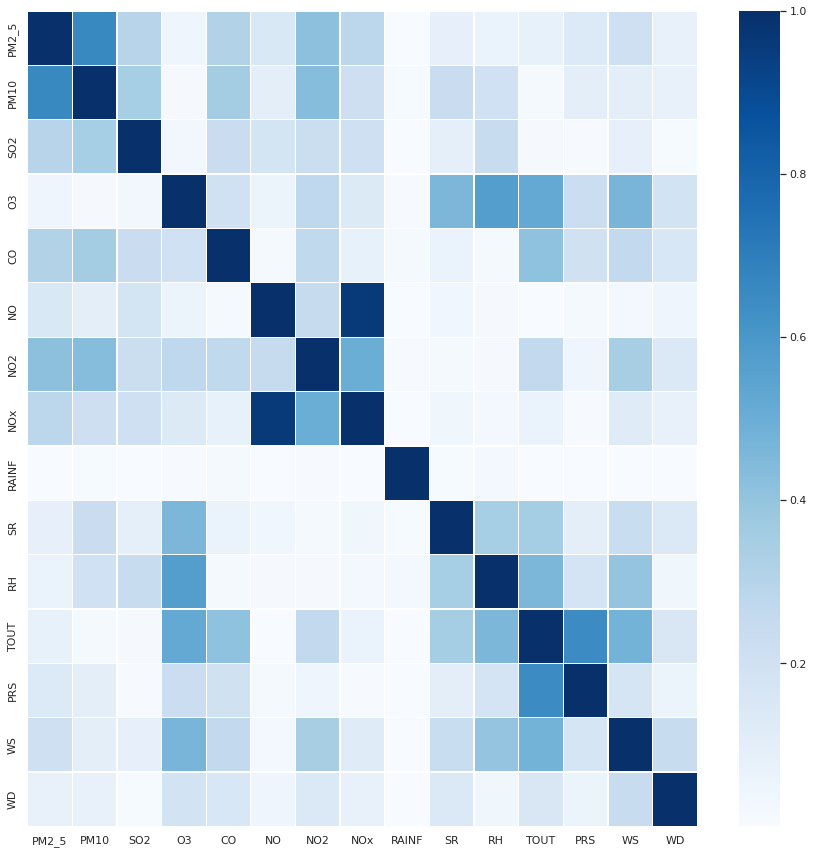

In [ ]:
import seaborn as sms

# Apply for a last time the correlatio matrix to delete correlated columns 
cor_matrix = all_data.corr().abs()                         ## create the correlation Matrix
sms.set(rc = {'figure.figsize':(15,15)})                  ## create a heatmap with the correlation matrix
sms.heatmap(cor_matrix,cmap="Blues", xticklabels=True, yticklabels=True, linewidth=0.3)

In [ ]:
flags_list = flags(all_dict)
flags_list

['p', 'r', 'd', 'x', 'l', 'm', 'a', 'e', 'n', 's', 'u', 'D', 'o', 'k']

In [ ]:
summary_flags = merge_flags(all_dict, flags_list)
summary_flags

,Flags,PM10,PM2_5,SO2,O3,CO,NO,NO2,NOx,TOUT,RH,SR,RAINF,PRS,WS,WD
0,p,17,10,0,17,17,17,17,17,17,16,17,130,11,18,17
1,r,0,2758,0,0,0,0,0,0,0,0,0,0,0,0,0
2,d,1,176,0,2,2,2,2,2,1,1,1,0,1,1,0
3,x,635,4025,12347,3949,1,1185,119,119,903,876,630,2582,796,806,820
4,l,169,1,1161,41,1,1,869,1,0,2,201,0,0,27,16
5,m,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,a,164,3324,0,0,10890,0,0,0,0,0,0,0,0,0,0
7,e,0,0,3494,1243,0,7124,7047,6941,0,0,0,0,0,0,0
8,n,192,190,98,192,156,1,1,1,192,192,193,192,193,192,192
9,s,24,27,1807,1993,0,1983,945,1465,4,45,0,0,0,25,4


In [ ]:
pollu_data.cov()

,PM2_5,PM10,SO2,O3,CO,NO,NO2,NOx
PM2_5,245.809180,359.887227,0.012259,-0.016105,5.731180,0.033824,0.046463,0.079156
PM10,359.887227,1192.019012,0.031407,0.010651,13.985559,0.083430,0.102500,0.183321
SO2,0.012259,0.031407,0.000007,0.000002,0.000725,0.000007,0.000004,0.000010
O3,-0.016105,0.010651,0.000002,0.000403,-0.004628,-0.000028,-0.000040,-0.000071
CO,5.731180,13.985559,0.000725,-0.004628,1.231424,0.000222,0.001759,0.001245
NO,0.033824,0.083430,0.000007,-0.000028,0.000222,0.000516,0.000040,0.000571
NO2,0.046463,0.102500,0.000004,-0.000040,0.001759,0.000040,0.000048,0.000087
NOx,0.079156,0.183321,0.000010,-0.000071,0.001245,0.000571,0.000087,0.000618


In [ ]:
meteo_data.cov()

,RAINF,SR,RH,TOUT,PRS,WS,WD
RAINF,0.013155,-0.000283,0.048226,-0.000260,-0.000291,-0.001135,-0.006614
SR,-0.000283,0.053801,-1.644004,0.563757,-0.082669,0.212147,-2.878988
RH,0.048226,-1.644004,408.414752,-62.976952,12.712942,-27.762477,-69.423142
TOUT,-0.000260,0.563757,-62.976952,46.689080,-15.524006,11.271425,-89.741343
PRS,-0.000291,-0.082669,12.712942,-15.524006,12.471603,-2.043211,-16.815334
WS,-0.001135,0.212147,-27.762477,11.271425,-2.043211,14.837453,-81.397709
WD,-0.006614,-2.878988,-69.423142,-89.741343,-16.815334,-81.397709,7395.103696


In [ ]:
df_stats(all_data)

,N,N*,Mean,SE Mean,StdDev,Var,Minimum,Maximum,Q1,Median,Q3,Mode
PM2_5,28882.0,10512,23.941130,0.092254,15.678303,245.809180,2.1700,225.3700,12.6100,20.0000,31.2400,9.0000
PM10,37712.0,1682,52.204350,0.177788,34.525628,1192.019012,2.0000,735.0000,29.0000,45.0000,67.0000,29.0000
SO2,20485.0,18909,0.004295,0.000018,0.002594,0.000007,0.0005,0.0619,0.0027,0.0035,0.0052,0.0034
O3,31956.0,7438,0.028361,0.000112,0.020079,0.000403,0.0010,0.1480,0.0120,0.0250,0.0400,0.0060
CO,28308.0,11086,2.067369,0.006596,1.109695,1.231424,0.0800,14.6000,1.2400,2.0200,2.6500,2.1600
NO,29080.0,10314,0.011454,0.000133,0.022717,0.000516,0.0005,0.5000,0.0027,0.0054,0.0119,0.0015
NO2,30320.0,9074,0.009013,0.000040,0.006949,0.000048,0.0005,0.0781,0.0039,0.0072,0.0125,0.0047
NOx,30846.0,8548,0.019408,0.000142,0.024857,0.000618,0.0010,0.5000,0.0069,0.0128,0.0232,0.0153
RAINF,36487.0,2907,0.001651,0.000600,0.114694,0.013155,0.0000,17.5000,0.0000,0.0000,0.0000,0.0000
SR,38548.0,846,0.186296,0.001181,0.231950,0.053801,0.0000,1.0960,0.0060,0.1660,0.1830,0.0060
